In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle
import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot

from keras_tqdm import TQDMNotebookCallback

from sklearn import metrics

Using TensorFlow backend.


In [2]:
training_frame = pickle.load( open( '../../Data/RentalListingData/full_set_with_images_and_features.pkl', 'rb' ) )

In [3]:
def plotImage(sample):
    plt.figure(figsize=(8,8))
    plt.imshow(sample)
    plt.show()

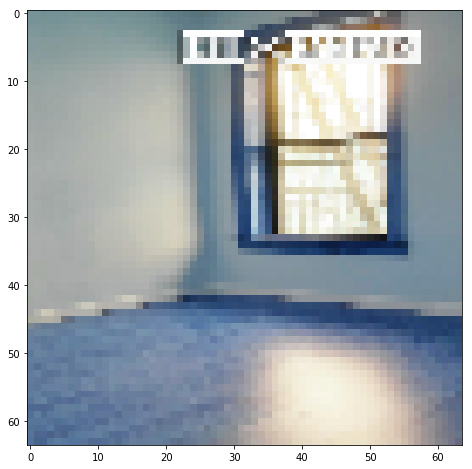

In [4]:
plotImage(training_frame.ix[32,1])

In [5]:
training_list_1 = list(training_frame.ix[:,1])
training_list_2 = list(training_frame.ix[:,2])
training_list_3 = list(training_frame.ix[:,3])
#training_list_4 = list(training_frame.ix[:,4])
#training_list_5 = list(training_frame.ix[:,5])

In [7]:
def clean_training_images(training_list):
    tmp_list = []
    for img in tqdm(training_list):
        try:
            tmp_list.append(np.reshape(np.array(img),(64,64,3)))
        except:
            tmp_list.append(np.array(np.reshape(np.zeros((64*3,64),np.float16),newshape=(64,64,3) )).astype(np.float16))
    return(tmp_list)

In [8]:
training_list_1 = clean_training_images(training_list_1)
training_list_2 = clean_training_images(training_list_2)
training_list_3 = clean_training_images(training_list_3)
#training_list_4 = clean_training_images(training_list_4)
#training_list_5 = clean_training_images(training_list_5)

100%|████████████████████████████████████████████████████████████████████████| 45397/45397 [00:00<00:00, 103370.64it/s]


In [9]:
training_list_1 = np.array(training_list_1)#.astype(float)
training_list_2 = np.array(training_list_2)#.astype(float)
training_list_3 = np.array(training_list_3)#.astype(float)
#training_list_4 = np.array(training_list_4).astype(float)
#training_list_5 = np.array(training_list_5).astype(float)

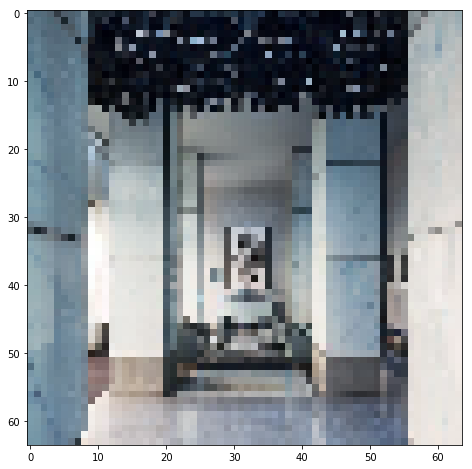

In [10]:
plotImage(training_list_1[45])

In [11]:
training_y = list(training_frame['interest_vector'])
training_y = np.array(training_y).astype(float)

In [12]:
training_y

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [13]:
print(np.shape(training_list_1))
print(np.shape(training_y))

(45397, 64, 64, 3)
(45397, 3)


# Set up neural net

In [19]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


image_input_1 = Input(shape=(64,64,3), name='image_input_1')
image_input_2 = Input(shape=(64,64,3), name='image_input_2')
image_input_3 = Input(shape=(64,64,3), name='image_input_3')
#image_input_4 = Input(shape=(256,256,3), name='image_input_4')
#image_input_5 = Input(shape=(256,256,3), name='image_input_5')

# shared vision.

generic_input = Input(shape=(64,64,3))

# vision model 1

model = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(generic_input)
model = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

# model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
# model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
# model = MaxPooling2D(pool_size=(2, 2))(model)

out = Flatten()(model)

vision_model_1 = Model(generic_input, out)

# vision model 2

model = Convolution2D(128, 5, 5, border_mode='same', activation='relu')(generic_input)
model = Convolution2D(128, 5, 5, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(model)
model = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

# model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
# model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
# model = MaxPooling2D(pool_size=(2, 2))(model)

out = Flatten()(model)

vision_model_2 = Model(generic_input, out)


# vision model 3

model = Convolution2D(32, 2, 2, border_mode='same', activation='relu')(generic_input)
model = Convolution2D(32, 2, 2, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(16, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(16, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(8, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(8, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

# model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
# model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
# model = MaxPooling2D(pool_size=(2, 2))(model)

out = Flatten()(model)

vision_model_3 = Model(generic_input, out)

out_1_1 = vision_model_1(image_input_1)
out_1_2 = vision_model_1(image_input_2)
out_1_3 = vision_model_1(image_input_3)
#out_4 = vision_model(image_input_4)
#out_5 = vision_model(image_input_5)

out_2_1 = vision_model_2(image_input_1)
out_2_2 = vision_model_2(image_input_2)
out_2_3 = vision_model_2(image_input_3)


out_3_1 = vision_model_3(image_input_1)
out_3_2 = vision_model_3(image_input_2)
out_3_3 = vision_model_3(image_input_3)


concatenated_1 = merge([out_1_1, out_1_2, out_1_3], mode='concat')
concatenated_2 = merge([out_2_1, out_2_2, out_2_3], mode='concat')
concatenated_3 = merge([out_3_1, out_3_2, out_3_3], mode='concat')

concatenated = merge([concatenated_1, concatenated_2], mode='concat')

model = Dense(256, activation='relu')(concatenated)
model = Dropout(0.5)(model)

model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)

output = Dense(3)(model)
output = Activation('softmax')(output)

classification_model = Model([image_input_1, image_input_2, image_input_3], output)
classification_model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

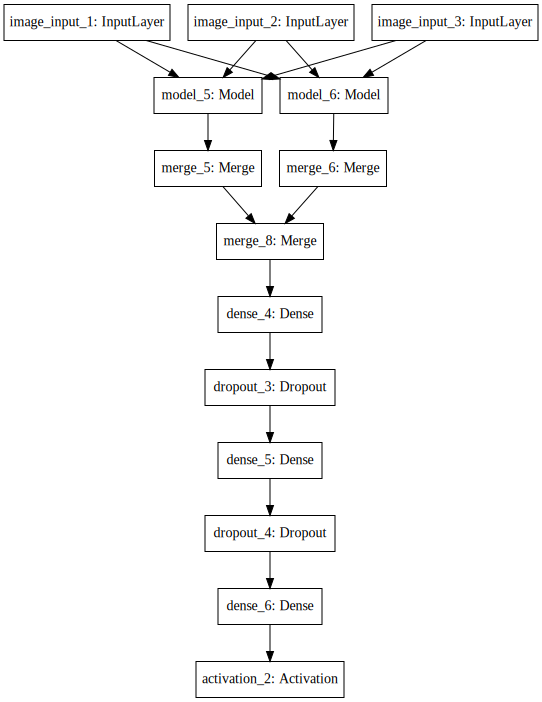

In [20]:
SVG(model_to_dot(classification_model).create(prog='dot', format='svg'))

In [21]:
nb_epoch = 5
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')     

In [22]:
history = LossHistory()

In [ ]:
classification_model.fit([training_list_1,training_list_2,training_list_3], training_y, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.15, verbose=0, shuffle=True, callbacks=[TQDMNotebookCallback(leave_inner = True, leave_outer = True), history])

In [ ]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [40]:
predictions = classification_model.predict([training_list_1,training_list_2,training_list_3], verbose=0)

I am 100.00% sure this property yields low interest
I was right!
1634


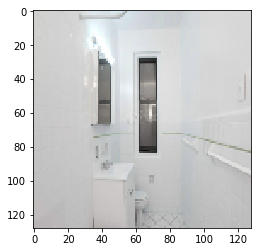

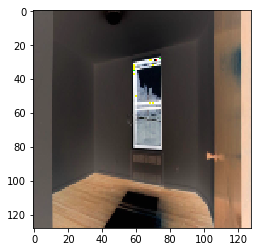

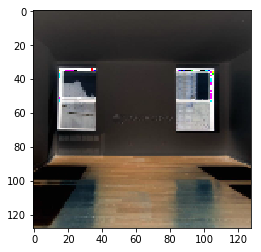

I am 100.00% sure this property yields low interest
I was right!
1197


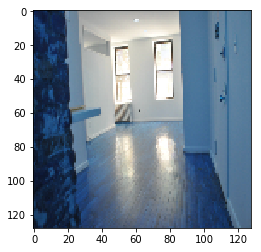

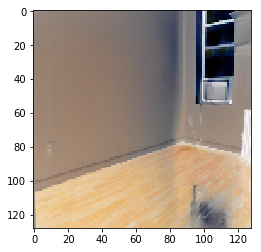

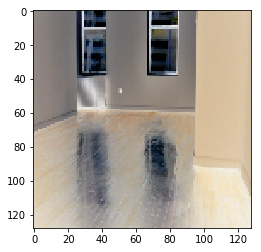

I am 100.00% sure this property yields low interest
I was right!
947


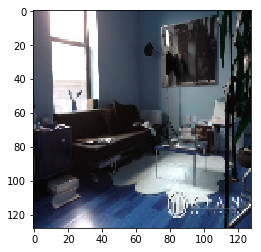

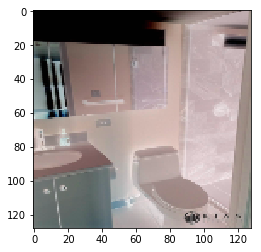

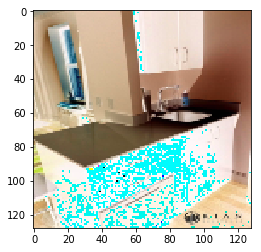

I am 100.00% sure this property yields low interest
I was right!
1707


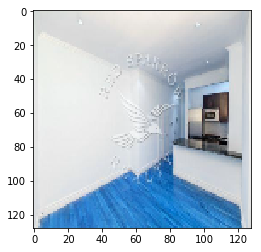

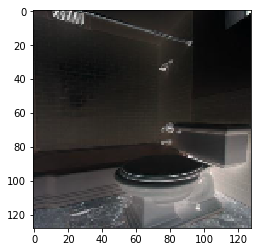

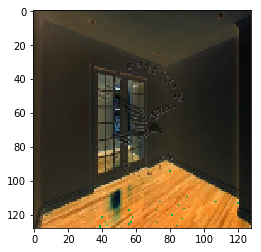

I am 100.00% sure this property yields low interest
I was right!
1878


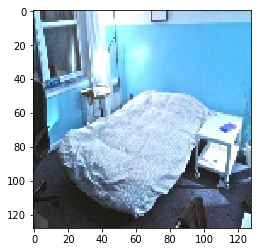

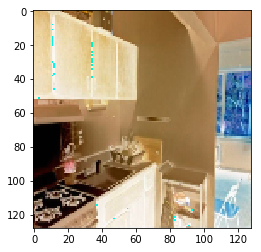

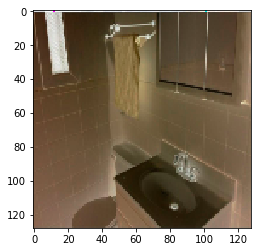

I am 100.00% sure this property yields low interest
I was right!
51


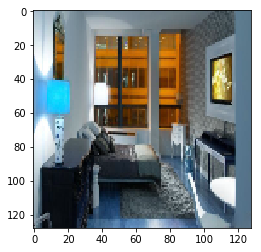

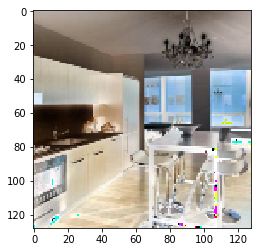

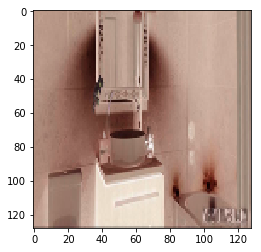

I am 100.00% sure this property yields low interest
I was right!
1050


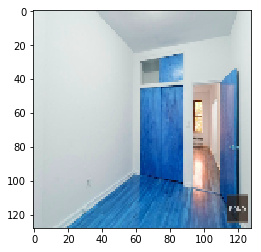

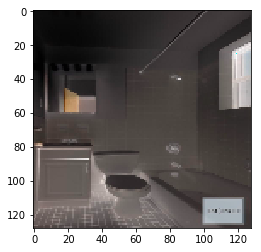

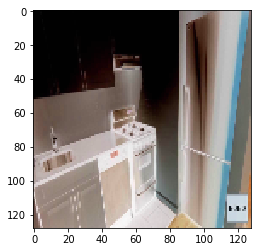

I am 100.00% sure this property yields low interest
I was right!
1808


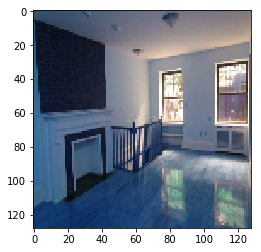

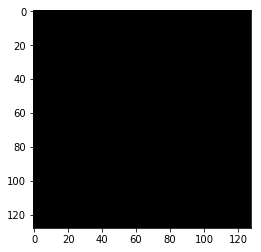

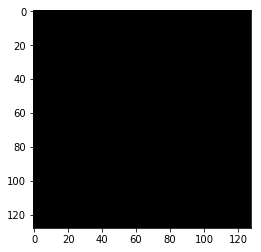

I am 100.00% sure this property yields low interest
I was right!
902


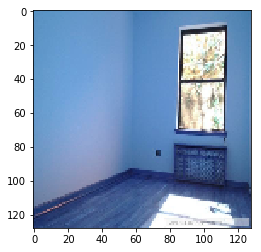

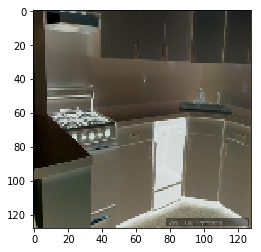

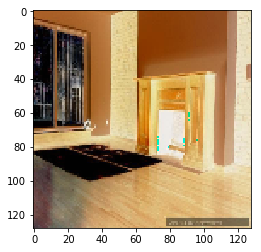

I am 100.00% sure this property yields low interest
I was right!
591


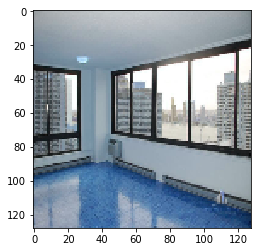

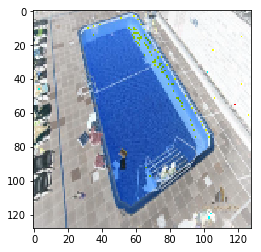

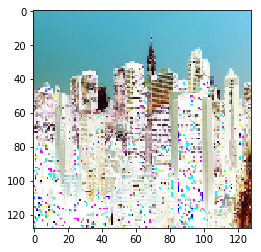

I am 100.00% sure this property yields low interest
I was wrong 
940


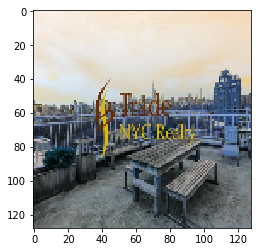

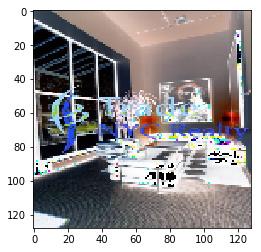

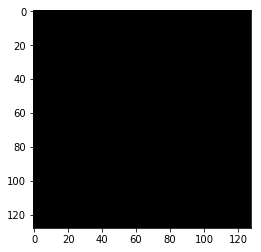

I am 100.00% sure this property yields low interest
I was right!
1862


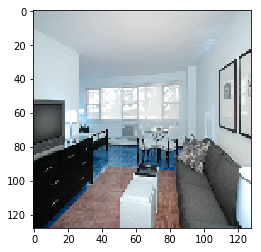

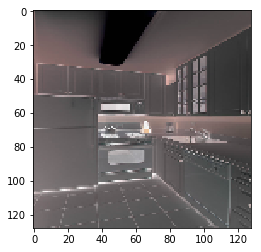

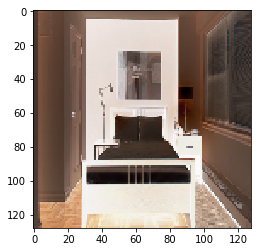

I am 100.00% sure this property yields low interest
I was wrong 
706


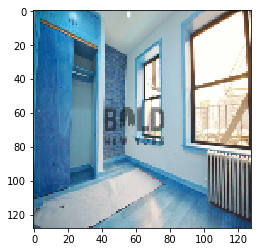

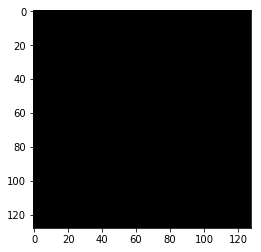

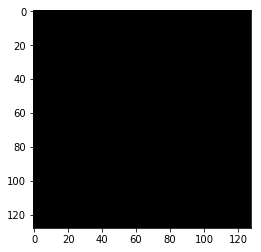

I am 100.00% sure this property yields low interest
I was wrong 
62


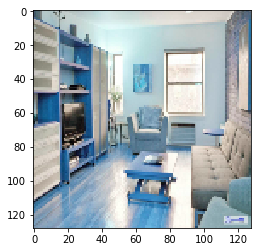

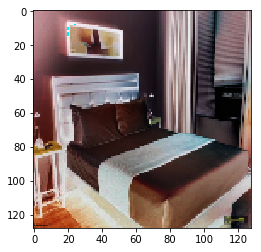

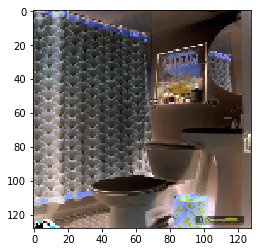

I am 100.00% sure this property yields low interest
I was wrong 
325


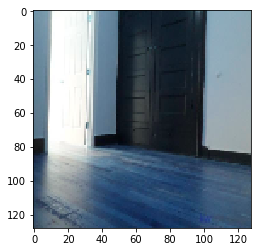

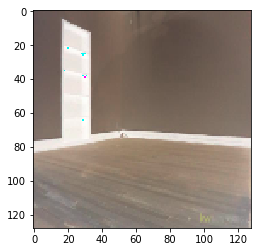

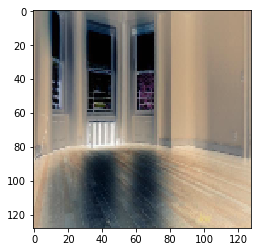

In [37]:
indx = 0

for i in np.random.randint(0,1900,15):
    if predictions[i][0] >= 0.5: 
        print('I am {:.2%} sure this property yields low interest'.format(predictions[i][0]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [1,0,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[i][1] >= 0.5:
        print('I am {:.2%} sure this property yields medium interest'.format(predictions[i][1]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [0,1,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[i][2] >= 0.5:
        print('I am {:.2%} sure this propertry yields high interest'.format(predictions[i][2]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [0,0,1]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    else:
        print('Im not really sure what interest this property yields')
        print(i)
        
    plt.imshow(training_list_1[i])
    plt.show()
    plt.imshow(training_list_2[i])
    plt.show()
    plt.imshow(training_list_3[i])
    plt.show()
    
#     plt.imshow(training_x_clean[i])
#     plt.show()

In [23]:
training_y[i]

array([ 0.,  1.,  0.])

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [48]:
for i in range(3):
    fpr[i], tpr[i], _ = metrics.roc_curve(training_y[:, i], predictions[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [50]:
roc_auc

{0: 0.5, 1: 0.5, 2: 0.5}